<a href="https://colab.research.google.com/github/Meddhif13/IASD/blob/main/1_agnews_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install datasets transformers

In [ ]:
from transformers import BertTokenizer

# Machine Learning for NLP

# Building blocks

In this part, we will discover how to build a first neural network for text classification, step by step.

🚧 **TODO** 🚧

Propose a chain of operations that should be applied to the input text, from the input to the output.
When it applies, write the dimension of the expected tensors.

**Answer**

TODO

## Tokenizer

During the last course and during the HW, you used a `WhiteSpaceTokenizer` to tokenize the text.

Here, we are going to use the tokenizer from the model `Bert`, that we will describe later in the course. It comes with the `transformers` library.

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

In [ ]:
sent = "I love footballing"
tokens = tokenizer.encode(sent)
ids = tokenizer.encode(sent)
for i in ids:
    print(i, tokenizer.ids_to_tokens[i])


101 [CLS]
1045 i
2293 love
2374 football
2075 ##ing
102 [SEP]


**Dataset**

We will use the AGNews dataset. It is a dataset with 4 classes: World, Sports, Business, Sci/Tech. We download it from HuggingFace Hub [here](https://huggingface.co/datasets/fancyzhx/ag_news).

In [ ]:
from datasets import load_dataset
import unicodedata
import re

dataset = load_dataset("fancyzhx/ag_news")
dataset = dataset["train"]
dataset = dataset.shuffle(seed=42)
dataset = dataset.select(range(3000))
dataset = dataset.train_test_split(test_size=0.3)

print(dataset)


def preprocess_text(text: str) -> str:
    # TODO lower case
    text = text.lower()

    # TODO string normalization.
    text = unicodedata.normalize("NFD", text).encode("ascii", "ignore").decode()

    # TODO remove non alpha numeric characters.
    text = re.sub(r"[^a-z0-9]", " ", text)

    # TODO replace numbers by the <NUM> token.
    text = re.sub(r"\d+", "<NUM>", text)

    # TODO remove double whitespaces.
    text = re.sub(" +", " ", text.strip())
    return text


# Clean the dataset
dataset = dataset.map(lambda x: {"text": preprocess_text(x["text"])})

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2100
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 900
    })
})


Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

## Word vectors

The first step since we have access to text in a tokenized form is to use word embeddings.

### Embeddings


🚧 **TODO** 🚧

Experiment with the class `nn.Embedding` from PyTorch.

Construct an embedding layer with:
- `d_embed=50` dimensions
- `n_vocab=V` words in the vocabulary

Then try to get the embedding of the following sentence: `"I love machine learning."`.

In [ ]:
print(len(tokenizer))

30522


In [ ]:
from torch import nn
import torch
d_embed=5
n_vocab=len(tokenizer)

embedding_models = nn.Embedding(num_embeddings=n_vocab, embedding_dim= d_embed)

sentence = "I love machine learning"
tokens = tokenizer(sentence, return_tensors="pt")["input_ids"]
print('Token ids:', tokens)
vectors = embedding_models(tokens)
print('Embedding:')
# TODO
print(vectors)

Token ids: tensor([[ 101, 1045, 2293, 3698, 4083,  102]])
Embedding:
tensor([[[-0.4148, -0.9911,  1.3767,  0.9707, -1.5581],
         [-0.1970,  2.1105, -0.1314,  0.1659,  0.7836],
         [-0.5597,  0.4638, -0.4771,  0.5890,  1.5528],
         [ 0.3601,  0.0794, -0.8231, -0.0471,  0.0981],
         [ 0.4764,  0.2930,  0.5099, -0.6649,  1.1533],
         [ 0.7469, -1.4753,  1.5888, -1.9025, -0.3251]]],
       grad_fn=<EmbeddingBackward0>)


In [ ]:
sentence = "I love Paris"
tokens = tokenizer(sentence, return_tensors="pt")["input_ids"]
print('Token ids:', tokens)
vectors = embedding_models(tokens)
print('Embedding:')
# TODO
print(vectors)

Token ids: tensor([[ 101, 1045, 2293, 3000,  102]])
Embedding:
tensor([[[-0.4148, -0.9911,  1.3767,  0.9707, -1.5581],
         [-0.1970,  2.1105, -0.1314,  0.1659,  0.7836],
         [-0.5597,  0.4638, -0.4771,  0.5890,  1.5528],
         [-1.1506,  0.4744,  0.5668,  0.2478, -0.4285],
         [ 0.7469, -1.4753,  1.5888, -1.9025, -0.3251]]],
       grad_fn=<EmbeddingBackward0>)


❗ CLS and SEP tensors remain thesame throughout different sentences using the same model

### Aggregation function

Since we need to perform document classfications, we need to aggregate the embeddings into a single vector of size `d`.

### Classification

The last layer of the network should be a linear layer with `c` classes.

🚧 **TODO** 🚧

Write a class named "WordEmbedClassifier" that will take as input a list of ids and return the probability of each class.

In [ ]:
class WordEmbedClassifier(nn.Module):
    def __init__(self, vocab_size, d, n_classes=4):
        super().__init__()
        # TODO
        self.embedding_layer = nn.Embedding(num_embeddings= vocab_size, embedding_dim= d)
        self.class_projection = nn.Linear(d, n_classes)

    def forward(self, x):
        # x(B, L) B= Batch size et L = length
        x_embed = self.embedding_layer(x) # (B, L, d)
        x_vector = x_embed.mean(axis=1) #(B, d)
        class_scores =  self.class_projection(x_vector) #(B, n_classes)

        #class_proba = torch.softmax(class_logits, dim=1)
        return class_scores

In [ ]:
# Try the model on a simple input:
length = 10
model = WordEmbedClassifier(d=5, n_classes=4, vocab_size=len(tokenizer))
x = tokenizer(("I live Paris", "I live London"), return_tensors="pt")["input_ids"]
print(x.shape)
output = model(x)
print(output)

torch.Size([2, 5])
tensor([[-0.4427, -0.3354,  0.0342,  0.0596],
        [-0.3627, -0.1528, -0.0270, -0.1088]], grad_fn=<AddmmBackward0>)


## Training

For training we need to iterate over the dataset.

### Data preparation

Here, we will assume that all texts have the same length, using truncation and discarding examples.

🚧 **Question** 🚧

Why do we need to have inputs of the same length?

**Answer**

Because we put them into tensors.

In [ ]:
def tokenize_truncate_and_discard(texts_list, labels_list, tokenizer, length=50):
    new_texts = []
    new_labels = []
    for text, label in zip(texts_list, labels_list):
        tokenized_text = tokenizer.encode(text)
        if len(tokenized_text) < length:
            continue
        new_texts.append(tokenized_text[:length])
        new_labels.append(label)

    return new_texts, new_labels


train_texts, train_labels = tokenize_truncate_and_discard(
    dataset["train"]["text"], dataset["train"]["label"], tokenizer
)
test_texts, test_labels = tokenize_truncate_and_discard(
    dataset["test"]["text"], dataset["test"]["label"], tokenizer
)

train_dataset = [(t, l) for t, l in zip(train_texts, train_labels)]
valid_dataset = [(t, l) for t, l in zip(test_texts, test_labels)]

print("Size before truncating:", len(dataset["train"]["text"]))
print("Size after truncating:", len(train_texts))

Size before truncating: 2100
Size after truncating: 931


Now we need to make batches of examples. We will use the DataLoader class from PyTorch.

🚧 **TODO** 🚧

Load the data into batches. One batch should be a dictionary with the following keys:
- `"input_ids"`: tensor of size (batch_size, L)
- `"labels"`: tensor of size (batch_size,)

In [ ]:
from torch.utils.data import DataLoader


class DataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        # `batch` is a list of tuples (text, label)
        texts, labels = zip(*batch)
        # Encode the texts
        return {"input_ids": torch.tensor(texts), "labels": torch.tensor(labels)}


data_collator = DataCollator(tokenizer)

batch_size = 32

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, collate_fn= data_collator, shuffle=True)
valid_dataloader = DataLoader(
    valid_dataset, batch_size=batch_size, collate_fn= data_collator, shuffle=True)
n_valid = len(valid_dataset)
n_train = len(train_dataset)

🔴 **TEST**

In [ ]:
batch = next(iter(train_dataloader))
print(batch)
assert isinstance(batch, dict)
assert "input_ids" in batch
assert "labels" in batch
assert isinstance(batch["input_ids"], torch.Tensor)
assert isinstance(batch["labels"], torch.Tensor)
assert batch["input_ids"].shape[0] == batch_size
assert batch["labels"].shape[0] == batch_size

{'input_ids': tensor([[  101,  2796,  4007,  ...,  1028,  3867,  6012],
        [  101,  2048,  4599,  ...,  2012,  1996,  5196],
        [  101,  7380, 16371,  ...,  2400,  2005,  2190],
        ...,
        [  101,  5088, 11956,  ...,  1028,  1026, 16371],
        [  101,  2563,  3786,  ..., 16371,  2213,  1028],
        [  101,  4238,  2758,  ..., 12707, 10631,  2056]]), 'labels': tensor([3, 1, 1, 3, 3, 2, 1, 2, 0, 1, 2, 3, 1, 1, 2, 3, 1, 0, 1, 1, 1, 3, 1, 2,
        1, 1, 2, 0, 3, 1, 1, 0])}


### Training loop

🚧 **TODO** 🚧

Now write the training loop. Validate the model on the validation set every epoch. Don't forget to plot the learning curves.

Epoch 1: train_loss: 1.3208, train_accuracy: 0.3867, valid_loss: 1.2266, valid_accuracy: 0.5061
Epoch 2: train_loss: 1.0075, train_accuracy: 0.7089, valid_loss: 0.9831, valid_accuracy: 0.6472
Epoch 3: train_loss: 0.5710, train_accuracy: 0.8926, valid_loss: 0.7496, valid_accuracy: 0.7445
Epoch 4: train_loss: 0.2606, train_accuracy: 0.9646, valid_loss: 0.6487, valid_accuracy: 0.7956
Epoch 5: train_loss: 0.1228, train_accuracy: 0.9871, valid_loss: 0.6073, valid_accuracy: 0.8054
Epoch 6: train_loss: 0.0644, train_accuracy: 0.9957, valid_loss: 0.5996, valid_accuracy: 0.8127
Epoch 7: train_loss: 0.0382, train_accuracy: 0.9979, valid_loss: 0.5873, valid_accuracy: 0.8102
Epoch 8: train_loss: 0.0254, train_accuracy: 1.0000, valid_loss: 0.5852, valid_accuracy: 0.8102
Epoch 9: train_loss: 0.0188, train_accuracy: 1.0000, valid_loss: 0.5873, valid_accuracy: 0.8102
Epoch 10: train_loss: 0.0148, train_accuracy: 1.0000, valid_loss: 0.5862, valid_accuracy: 0.8102


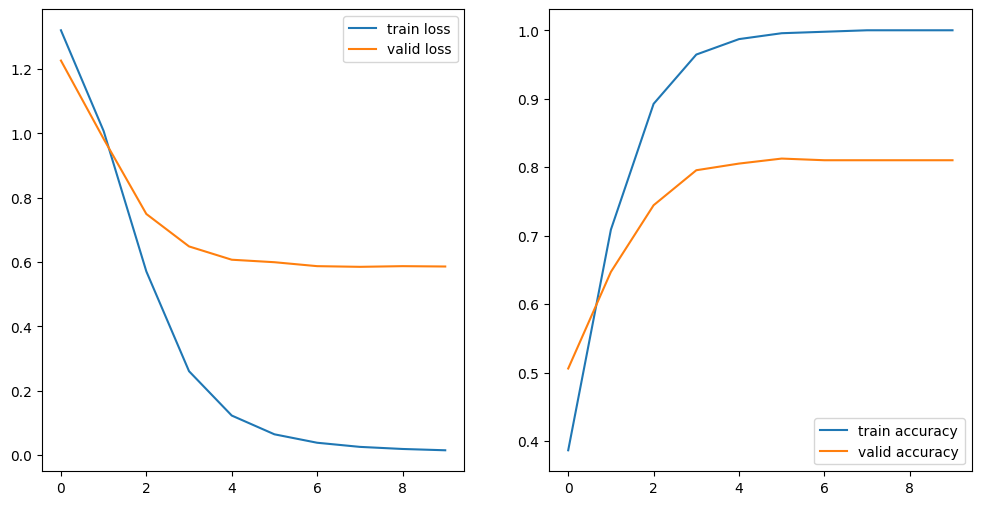

In [ ]:
import matplotlib.pyplot as plt
from torch import optim


# TODO
def validation_step(valid_dataloader, model, criterion):
    n_valid = len(valid_dataloader.dataset)
    model.eval()
    total_loss = 0.0
    correct = 0
    n_iter = 0

    with torch.no_grad():
        for batch in valid_dataloader:
            input_ids = batch["input_ids"]
            labels = batch["labels"]
            output = model(input_ids)
            loss = criterion(output, labels)
            total_loss += loss.item()
            correct += (output.argmax(axis=-1) == labels).sum().item()
            n_iter += 1

    return total_loss / n_iter, correct / n_valid


def train_one_epoch(train_dataloader, model, optimizer, criterion):
    model.train()
    total_loss = 0.0
    correct = 0
    n_train = len(train_dataloader.dataset)
    n_iter = 0
    for batch in train_dataloader:
        optimizer.zero_grad() #init the parameters to 0, good practivce
        class_scores = model(batch["input_ids"]) #(B, 4)

        loss = criterion(class_scores, batch["labels"]) # scalaire (1,)
        loss.backward()
        optimizer.step()


        total_loss += loss.item()
        correct += (class_scores.argmax(axis=-1) == batch["labels"]).sum().item() # .item to convert to python float
        n_iter += 1

    return total_loss / n_iter, correct / n_train


def train(model, train_dataloader, valid_dataloader, lr=0.01, n_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    # Track training loss, training accuracy, validation loss and validation accuracy and plot in the end
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []

    for epoch in range(n_epochs):
        train_loss, train_accuracy = train_one_epoch(
            train_dataloader, model, optimizer, criterion
        )
        valid_loss, valid_accuracy = validation_step(valid_dataloader, model, criterion)
        print(
            f"Epoch {epoch + 1}: train_loss: {train_loss:.4f}, train_accuracy: {train_accuracy:.4f}, valid_loss: {valid_loss:.4f}, valid_accuracy: {valid_accuracy:.4f}"
        )
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="train loss")
    plt.plot(valid_losses, label="valid loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="train accuracy")
    plt.plot(valid_accuracies, label="valid accuracy")
    plt.legend()


model = WordEmbedClassifier(d=50, n_classes=4, vocab_size=len(tokenizer))

train(model, train_dataloader, valid_dataloader, n_epochs=10)

🚧 **TODO** 🚧

What do you think about the learning curves ?

✅ **Answer** ✅



## Padding and masking

Up to know, we assumed that our texts have the same length. To achieve that, we truncated the texts. However, in practive we want to keep the full texts (up to a given limit, of course)

We will investigate masking and padding to handle texts of different lengths.

🚧 **Question** 🚧

- What will padding achieve?
- What should we be careful about when using padding model?

**Answer**

TODO


In [ ]:
class DataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        # Tokenize the texts
        texts = [example["text"] for example in batch]
        labels = [example["label"] for example in batch]
        tokenized_texts = [self.tokenizer.encode(text) for text in texts]
        # Pad the tokenized texts
        max_len = max(len(text) for text in tokenized_texts)
        padded_texts = [
            text + [self.tokenizer.pad_token_id] * (max_len - len(text))
            for text in tokenized_texts
        ]
        pad_mask = [
            [1] * len(text) + [0] * (max_len - len(text)) for text in tokenized_texts
        ]
        return {
            "input_ids": torch.tensor(padded_texts),
            "pad_mask": torch.tensor(pad_mask),
            "labels": torch.tensor(labels),
        }


batch_size = 32
n_train = len(dataset["train"])
n_valid = len(dataset["test"])
data_collator = DataCollator(tokenizer)
train_dataloader = DataLoader(
    dataset["train"], batch_size=batch_size, collate_fn=data_collator, shuffle=True
)
valid_dataloader = DataLoader(
    dataset["test"], batch_size=batch_size, collate_fn=data_collator, shuffle=True
)

In [ ]:
batch = next(iter(train_dataloader))
print(batch["input_ids"][:2, -50:])

tensor([[ 3296, 12195,  3514,  1998,  3806, 25335,  2000, 28805, 17401,  1998,
          5780,  2752,  1996,  2689,  2001,  2000,  3437, 11141, 10069,  1996,
          2801,  2453, 12996,  2062, 15827,  2125,  2037, 20266,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [ 2140, 12023,  2371,  2009,  2001,  3647,  2000,  3677,  1037,  7401,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]])


These zeros that the padding tokens represnt risk interfering with the calculations so we will need to handle them so the model doesn't learn it ad well.

🚧 **TODO** 🚧

Update the code of the `WordEmbedClassifier` to handle padding.


In [ ]:
class WordEmbedClassifier(nn.Module):
    def __init__(self, vocab_size, d, n_classes=4):
        super().__init__()
        self.embedding_layer = nn.Embedding(vocab_size, d)
        self.class_projection = nn.Linear(d, n_classes)

    def forward(self, input_ids, pad_mask):
        x_embed = self.embedding_layer(input_ids) #(B,L,d)
        #x_vector = x_embed.mean(axis=1)  # (B, d)

        n_non_pad = pad_mask.sum(axis=1, keepdim=True) # (B,)

        # pad_mask(B,L), x_embed(B, L, d)
        x_embed = x_embed * pad_mask.unsqueeze(-1)
        x_vector = x_embed.sum(axis=1) / n_non_pad  # (B, d)

        class_scores = self.class_projection(x_vector)  # (B, n_classes)

        # TODO

        return class_scores

🔴 **TEST**

In [ ]:
model = WordEmbedClassifier(d=50, n_classes=4, vocab_size=10000)

seq_len = 10
x_without_pad = torch.randint(0, 10000, (1, seq_len))
pad_mask = torch.ones(1, seq_len)
out_without_pad = model(x_without_pad, pad_mask)

x_with_pad = torch.randint(0, 10000, (1, 2 * seq_len))
pad_mask = torch.ones(1, 2 * seq_len)
pad_mask[:, seq_len:] = 0
out_with_pad = model(x_with_pad, pad_mask)

assert out_without_pad.shape == out_with_pad.shape

Epoch 1: train_loss: 1.2145, train_accuracy: 0.5067, valid_loss: 0.9251, valid_accuracy: 0.7011
Epoch 2: train_loss: 0.5520, train_accuracy: 0.8462, valid_loss: 0.5543, valid_accuracy: 0.8267
Epoch 3: train_loss: 0.2048, train_accuracy: 0.9524, valid_loss: 0.4797, valid_accuracy: 0.8344
Epoch 4: train_loss: 0.0836, train_accuracy: 0.9867, valid_loss: 0.4629, valid_accuracy: 0.8422
Epoch 5: train_loss: 0.0380, train_accuracy: 0.9981, valid_loss: 0.4581, valid_accuracy: 0.8422
Epoch 6: train_loss: 0.0209, train_accuracy: 0.9995, valid_loss: 0.4889, valid_accuracy: 0.8367
Epoch 7: train_loss: 0.0135, train_accuracy: 1.0000, valid_loss: 0.4656, valid_accuracy: 0.8389
Epoch 8: train_loss: 0.0098, train_accuracy: 1.0000, valid_loss: 0.5066, valid_accuracy: 0.8378
Epoch 9: train_loss: 0.0075, train_accuracy: 1.0000, valid_loss: 0.4914, valid_accuracy: 0.8411
Epoch 10: train_loss: 0.0060, train_accuracy: 1.0000, valid_loss: 0.4871, valid_accuracy: 0.8411


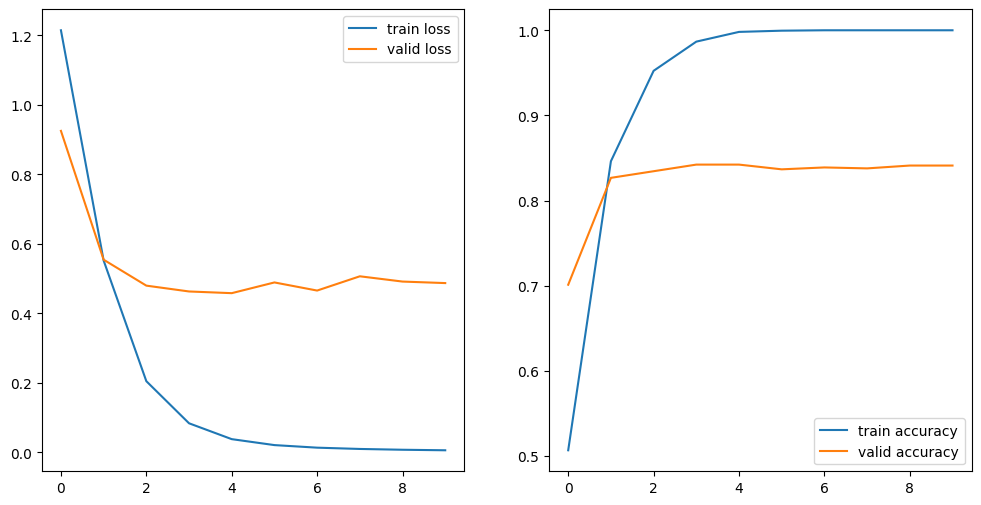

In [ ]:
import matplotlib.pyplot as plt
from torch import optim


# TODO
def validation_step(valid_dataloader, model, criterion):
    n_valid = len(valid_dataloader.dataset)
    model.eval()
    total_loss = 0.0
    correct = 0
    n_iter = 0

    with torch.no_grad():
        for batch in valid_dataloader:
            input_ids = batch["input_ids"]
            labels = batch["labels"]
            pad_mask= batch["pad_mask"]
            output = model(input_ids, pad_mask)
            loss = criterion(output, labels)
            total_loss += loss.item()
            correct += (output.argmax(axis=-1) == labels).sum().item()
            n_iter += 1

    return total_loss / n_iter, correct / n_valid


def train_one_epoch(train_dataloader, model, optimizer, criterion):
    model.train()
    total_loss = 0.0
    correct = 0
    n_train = len(train_dataloader.dataset)
    n_iter = 0
    for batch in train_dataloader:
        optimizer.zero_grad() #init the parameters to 0, good practivce
        class_scores = model(batch["input_ids"], batch["pad_mask"]) #(B, 4)

        loss = criterion(class_scores, batch["labels"]) # scalaire (1,)
        loss.backward()
        optimizer.step()


        total_loss += loss.item()
        correct += (class_scores.argmax(axis=-1) == batch["labels"]).sum().item() # .item to convert to python float
        n_iter += 1

    return total_loss / n_iter, correct / n_train


def train(model, train_dataloader, valid_dataloader, lr=0.01, n_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    # Track training loss, training accuracy, validation loss and validation accuracy and plot in the end
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []

    for epoch in range(n_epochs):
        train_loss, train_accuracy = train_one_epoch(
            train_dataloader, model, optimizer, criterion
        )
        valid_loss, valid_accuracy = validation_step(valid_dataloader, model, criterion)
        print(
            f"Epoch {epoch + 1}: train_loss: {train_loss:.4f}, train_accuracy: {train_accuracy:.4f}, valid_loss: {valid_loss:.4f}, valid_accuracy: {valid_accuracy:.4f}"
        )
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="train loss")
    plt.plot(valid_losses, label="valid loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="train accuracy")
    plt.plot(valid_accuracies, label="valid accuracy")
    plt.legend()


model = WordEmbedClassifier(d=50, n_classes=4, vocab_size=len(tokenizer))

train(model, train_dataloader, valid_dataloader, n_epochs=10)

Epoch 1: train_loss: 1.3520, train_accuracy: 0.3433, valid_loss: 1.2734, valid_accuracy: 0.4678
Epoch 2: train_loss: 1.0119, train_accuracy: 0.6986, valid_loss: 0.8872, valid_accuracy: 0.7111
Epoch 3: train_loss: 0.5362, train_accuracy: 0.8714, valid_loss: 0.6466, valid_accuracy: 0.7678
Epoch 4: train_loss: 0.2920, train_accuracy: 0.9310, valid_loss: 0.5729, valid_accuracy: 0.7978
Epoch 5: train_loss: 0.1721, train_accuracy: 0.9671, valid_loss: 0.5531, valid_accuracy: 0.8033
Epoch 6: train_loss: 0.1045, train_accuracy: 0.9862, valid_loss: 0.5273, valid_accuracy: 0.8056
Epoch 7: train_loss: 0.0672, train_accuracy: 0.9914, valid_loss: 0.5396, valid_accuracy: 0.8056
Epoch 8: train_loss: 0.0447, train_accuracy: 0.9986, valid_loss: 0.5254, valid_accuracy: 0.8056
Epoch 9: train_loss: 0.0319, train_accuracy: 0.9995, valid_loss: 0.5341, valid_accuracy: 0.8067
Epoch 10: train_loss: 0.0236, train_accuracy: 1.0000, valid_loss: 0.5443, valid_accuracy: 0.8122


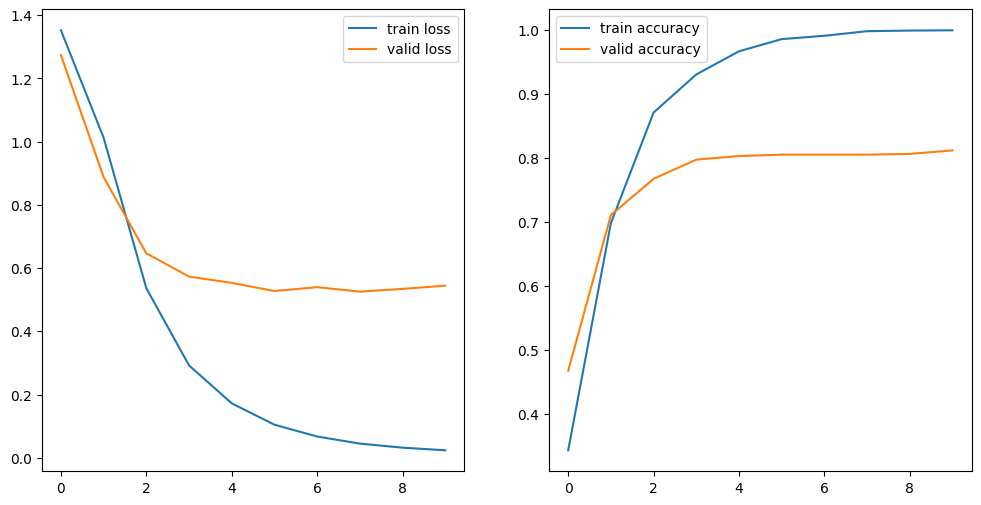

In [ ]:
model = WordEmbedClassifier(
    d=10,
    n_classes=4,
    vocab_size=len(tokenizer),
)
train(
    model,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    lr=0.01,
    n_epochs=10,
)

## Sequence processing module

Now we built a simple classifier using word embeddings.

But is our model really different from a simple bag-of-words model?

🚧 **Question** 🚧

How can we make our model more powerful?

**Answer**

Convolutoinal layer for the tokens (something like a sliding mean)
We can also use reoccurnet neural network to take the previous context in cosideration  

🚧 **Question** 🚧

What kind of module can we use?

**Answer**

TODO

## Convolution1D

Look at the documentation of the Conv1d layer. Read it carefully and try to completely understand the following code. A convolution layer expects a tensor as input, with the following dimensions *(B, D, L)*:
- B: size of the batch, the number of examples (here the number of sequences).
- D: the dimension of the vectors for each time step
- L: the length of the input sequence (the number of tokens in the sequence).

🚧 **Question** 🚧

Is this shape directly compatible with our Embeddings layer defined above?

🚧 **TODO** 🚧

- Make sure the following code computing a convolution run and is consistent.
- Draw what happens to better understand the obtained dimensions.

In [ ]:
d_embed = 50
embedding_layer = nn.Embedding(num_embeddings=len(tokenizer), embedding_dim=d_embed)

sequence_embedding = embedding_layer(batch["input_ids"][:2])
print("Sequence embedding shape:", sequence_embedding.shape)

convolution_layer = nn.Conv1d(in_channels=d_embed, out_channels=d_embed, kernel_size=3)
convolution_output = convolution_layer(sequence_embedding.transpose(1, 2)) #convolution input should be (B, D, L)
print("Convolution output shape:", convolution_output.shape)

Sequence embedding shape: torch.Size([2, 50, 50])
Convolution output shape: torch.Size([2, 50, 48])


🚧 **TODO** 🚧

Write a class named "Conv1dClassifier" that implements a convolutional neural network for text classification.

In [ ]:
class ConvClassifier(nn.Module):
    def __init__(self, vocab_size, d, n_classes=4):
        super().__init__()
        self.embedding_layer = nn.Embedding(vocab_size, d)
        self.class_projection = nn.Linear(d, n_classes)
        self.conv1 = nn.Conv1d(in_channels=d, out_channels=d, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=d, out_channels=d, kernel_size=3)

    def forward(self, input_ids, pad_mask):
            x_embed = self.embedding_layer(input_ids) #(B,L,d)
            x_embed = x_embed * pad_mask.unsqueeze(-1)
            x_embed = self.conv1(x_embed.transpose(1, 2)) # (B, d, L)
            x_embed = torch.relu(x_embed)
            x_embed = self.conv2(x_embed).transpose(1, 2) #convolution input should be (B, D, L
            #x_vector = x_embed.mean(axis=1)  # (B, d)
            pad_mask = pad_mask[:, 2:-2]
            n_non_pad = pad_mask.sum(axis=1, keepdim=True) # (B,)

            # pad_mask(B,L), x_embed(B, L, d)
            x_embed = x_embed * pad_mask[:, :, None] #or pad_mask[:, :, None]
            x_vector = x_embed.sum(axis=1) / n_non_pad  # (B, d)

            class_scores = self.class_projection(x_vector)  # (B, n_classes)

            # TODO

            return class_scores

Epoch 1: train_loss: 1.3923, train_accuracy: 0.2490, valid_loss: 1.3822, valid_accuracy: 0.2867
Epoch 2: train_loss: 1.3769, train_accuracy: 0.3048, valid_loss: 1.3772, valid_accuracy: 0.3044
Epoch 3: train_loss: 1.3603, train_accuracy: 0.3643, valid_loss: 1.3598, valid_accuracy: 0.3467
Epoch 4: train_loss: 1.3159, train_accuracy: 0.4024, valid_loss: 1.3068, valid_accuracy: 0.3711
Epoch 5: train_loss: 1.2230, train_accuracy: 0.4452, valid_loss: 1.2408, valid_accuracy: 0.4011
Epoch 6: train_loss: 1.1237, train_accuracy: 0.5005, valid_loss: 1.2013, valid_accuracy: 0.4822
Epoch 7: train_loss: 1.0307, train_accuracy: 0.5633, valid_loss: 1.1552, valid_accuracy: 0.5056
Epoch 8: train_loss: 0.9372, train_accuracy: 0.6152, valid_loss: 1.0890, valid_accuracy: 0.5456
Epoch 9: train_loss: 0.8465, train_accuracy: 0.6648, valid_loss: 1.0933, valid_accuracy: 0.5733
Epoch 10: train_loss: 0.7614, train_accuracy: 0.7100, valid_loss: 1.0394, valid_accuracy: 0.5911


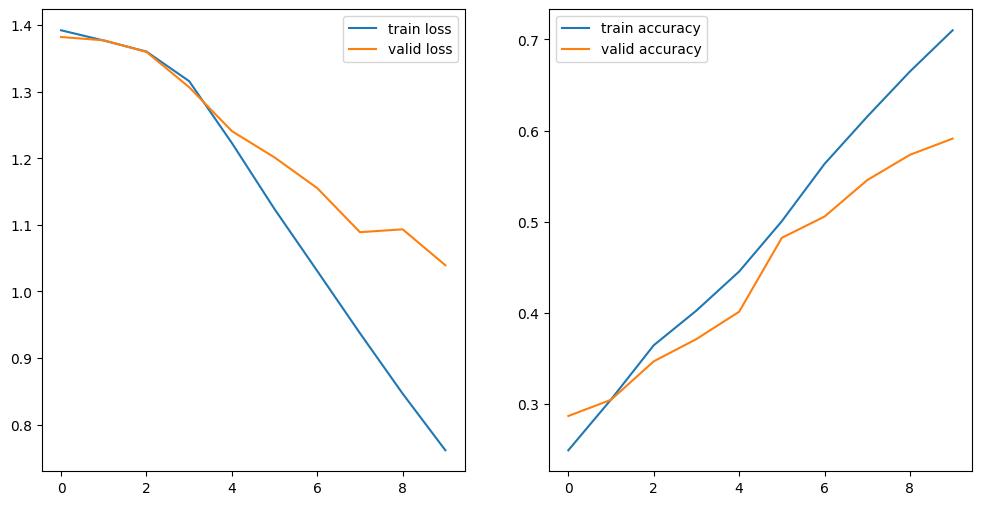

In [ ]:
model = ConvClassifier(
    d=10,
    n_classes=4,
    vocab_size=len(tokenizer),
)
train(
    model,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    lr=0.001,
    n_epochs=10,
)